In [1]:
import pandas as pd
import numpy as np
import pprint as pp
import pgeocode as pg
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import uniform, randint
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import warnings
import datetime

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('train.csv', sep=';')
df.head()

,Id,Tipo,FechaConstruccion,FechaReforma,Plantas,Plan,PAU,CatParcela,PerimParcela,Superficie,...,AguaCorriente,FosaSeptica,Situacion,CP,ProxCarretera,ProxCallePrincipal,ProxViasTren,Estado,RatingEstrellas,Precio
0,1,Chalet individual,2003,2003,2,Antiguo,0,Residencial unifamiliar,79.25,785.03,...,1,0,Interior,60061,0,0,0,5,3.5,375497
1,2,Chalet individual,1976,1976,1,Antiguo,0,Residencial unifamiliar,97.54,891.87,...,1,0,Frontal 2 lados,50018,0,1,0,8,3.0,339946
2,3,Chalet individual,2001,2002,2,Antiguo,0,Residencial unifamiliar,82.91,1045.16,...,1,0,Interior,60061,0,0,0,5,3.5,402511
3,4,Chalet individual,1915,1970,2,Nuevo,0,Residencial unifamiliar,73.15,887.22,...,1,0,Esquina,62451,0,0,0,5,3.5,272706
4,5,Chalet individual,2000,2000,2,Antiguo,0,Residencial unifamiliar,102.41,1324.80,...,1,0,Frontal 2 lados,60706,0,0,0,5,4.0,450236


In [3]:
variables_reales = df.columns[df.dtypes == 'float64']
variables_categoricas = df.dtypes[df.dtypes == 'object'].index
variables_enteras = df.columns[df.dtypes == 'int64']

print('Variables reales: ', variables_reales)
print('Variables categoricas: ', variables_categoricas)
print('Variables enteras: ', variables_enteras)

Variables reales:  Index(['PerimParcela', 'Superficie', 'RatingEstrellas'], dtype='object')
Variables categoricas:  Index(['Tipo', 'Plan', 'CatParcela', 'Formato', 'TipoDesnivel', 'Desnivel',
       'Situacion'],
      dtype='object')
Variables enteras:  Index(['Id', 'FechaConstruccion', 'FechaReforma', 'Plantas', 'PAU', 'Aseos',
       'Habitaciones', 'Garaje', 'Piscina', 'Vallada', 'CallePavimentada',
       'Callejon', 'GasNatural', 'AguaCorriente', 'FosaSeptica', 'CP',
       'ProxCarretera', 'ProxCallePrincipal', 'ProxViasTren', 'Estado',
       'Precio'],
      dtype='object')


In [4]:
def minmax_norm(df, variables_reales):
    for variable in variables_reales:
        df[variable] = (df[variable] - df[variable].min()) / (df[variable].max() - df[variable].min())
    return df

def zscore_norm(df, variables_reales):
    for variable in variables_reales:
        df[variable] = (df[variable] - df[variable].mean()) / df[variable].std()
    return df

def one_hot_encoding(df, variables_categoricas):
    return pd.get_dummies(df, columns=variables_categoricas, dtype=np.int64)

def extract_postal_hierarchy(df):
    df['CP'] = df['CP'].astype(str)
    df['postal_group'] = df['CP'].str[0]
    df['region'] = df['CP'].str[:3]
    df['specific_location'] = df['CP']
    return df

def zscore_norm_price(df):
    global price_mean, price_std
    price_mean = df['Precio'].mean()
    price_std = df['Precio'].std()
    df['Precio'] = (df['Precio'] - price_mean) / price_std
    return df

def zscore_norm_price_inverse(np_array):
    global price_mean, price_std
    return np_array * price_std + price_mean

df.drop(['Id', 'AguaCorriente', 'GasNatural', 'FosaSeptica'], axis=1, inplace=True)
df.dropna(inplace=True)
#df = extract_postal_hierarchy(df)

df['Reformada'] = df['FechaConstruccion'] != df['FechaReforma']
df['Reformada'] = df['Reformada'].astype(int)

# Assuming you've already loaded your dataframe as df

# Current Year
current_year = datetime.datetime.now().year
df['Aspect_Ratio'] = df['PerimParcela'] / df['Superficie']
df['HighRating'] = df['RatingEstrellas'].apply(lambda x: 1 if x > 4 else 0)
df['AgeOfHouse'] = current_year - df['FechaConstruccion']
df['YearsSinceReform'] = current_year - df['FechaReforma']
df['TotalRooms'] = df['Aseos'] + df['Habitaciones']
df['AvgProximity'] = (df['ProxCarretera'] + df['ProxCallePrincipal'] + df['ProxViasTren']) / 3

df = df.drop(['FechaConstruccion', 'FechaReforma'], axis=1)

# remove samples where price belongs to top 10% of the dataset
df = df[df['Precio'] < df['Precio'].quantile(0.85)]

variables_reales = df.columns[df.dtypes == 'float64']
variables_categoricas = df.dtypes[df.dtypes == 'object'].index
variables_enteras = df.columns[df.dtypes == 'int64']

variables_enteras = variables_enteras.drop(['Precio'])
df = zscore_norm(df, variables_reales)
df = zscore_norm(df, variables_enteras)
df = zscore_norm_price(df)
df = one_hot_encoding(df, variables_categoricas)

df.head()

,Plantas,PAU,PerimParcela,Superficie,Aseos,Habitaciones,Garaje,Piscina,Vallada,CallePavimentada,...,TipoDesnivel_Llana,TipoDesnivel_Muy irregular,Desnivel_Elevado,Desnivel_Ligero,Desnivel_Moderado,Situacion_Esquina,Situacion_Frontal 2 lados,Situacion_Frontal 3 lados,Situacion_Interior,Situacion_Trasero
0,1.355031,-0.405171,-0.149847,-0.205265,1.887977,1.448374,0.192456,-0.043396,-0.466347,0.043396,...,1,0,0,1,0,0,0,0,1,0
1,-0.736601,-0.405171,0.484389,0.085547,0.750048,-0.111639,0.192456,-0.043396,-0.466347,0.043396,...,1,0,0,1,0,0,1,0,0,0
2,1.355031,-0.405171,-0.022930,0.502794,1.887977,-0.111639,0.192456,-0.043396,-0.466347,0.043396,...,1,0,0,1,0,0,0,0,1,0
3,1.355031,-0.405171,-0.361374,0.072890,-0.387882,0.668367,0.192456,-0.043396,-0.466347,0.043396,...,1,0,0,1,0,1,0,0,0,0
4,1.355031,-0.405171,0.653264,1.263957,1.887977,2.228381,0.192456,-0.043396,-0.466347,0.043396,...,1,0,0,1,0,0,1,0,0,0


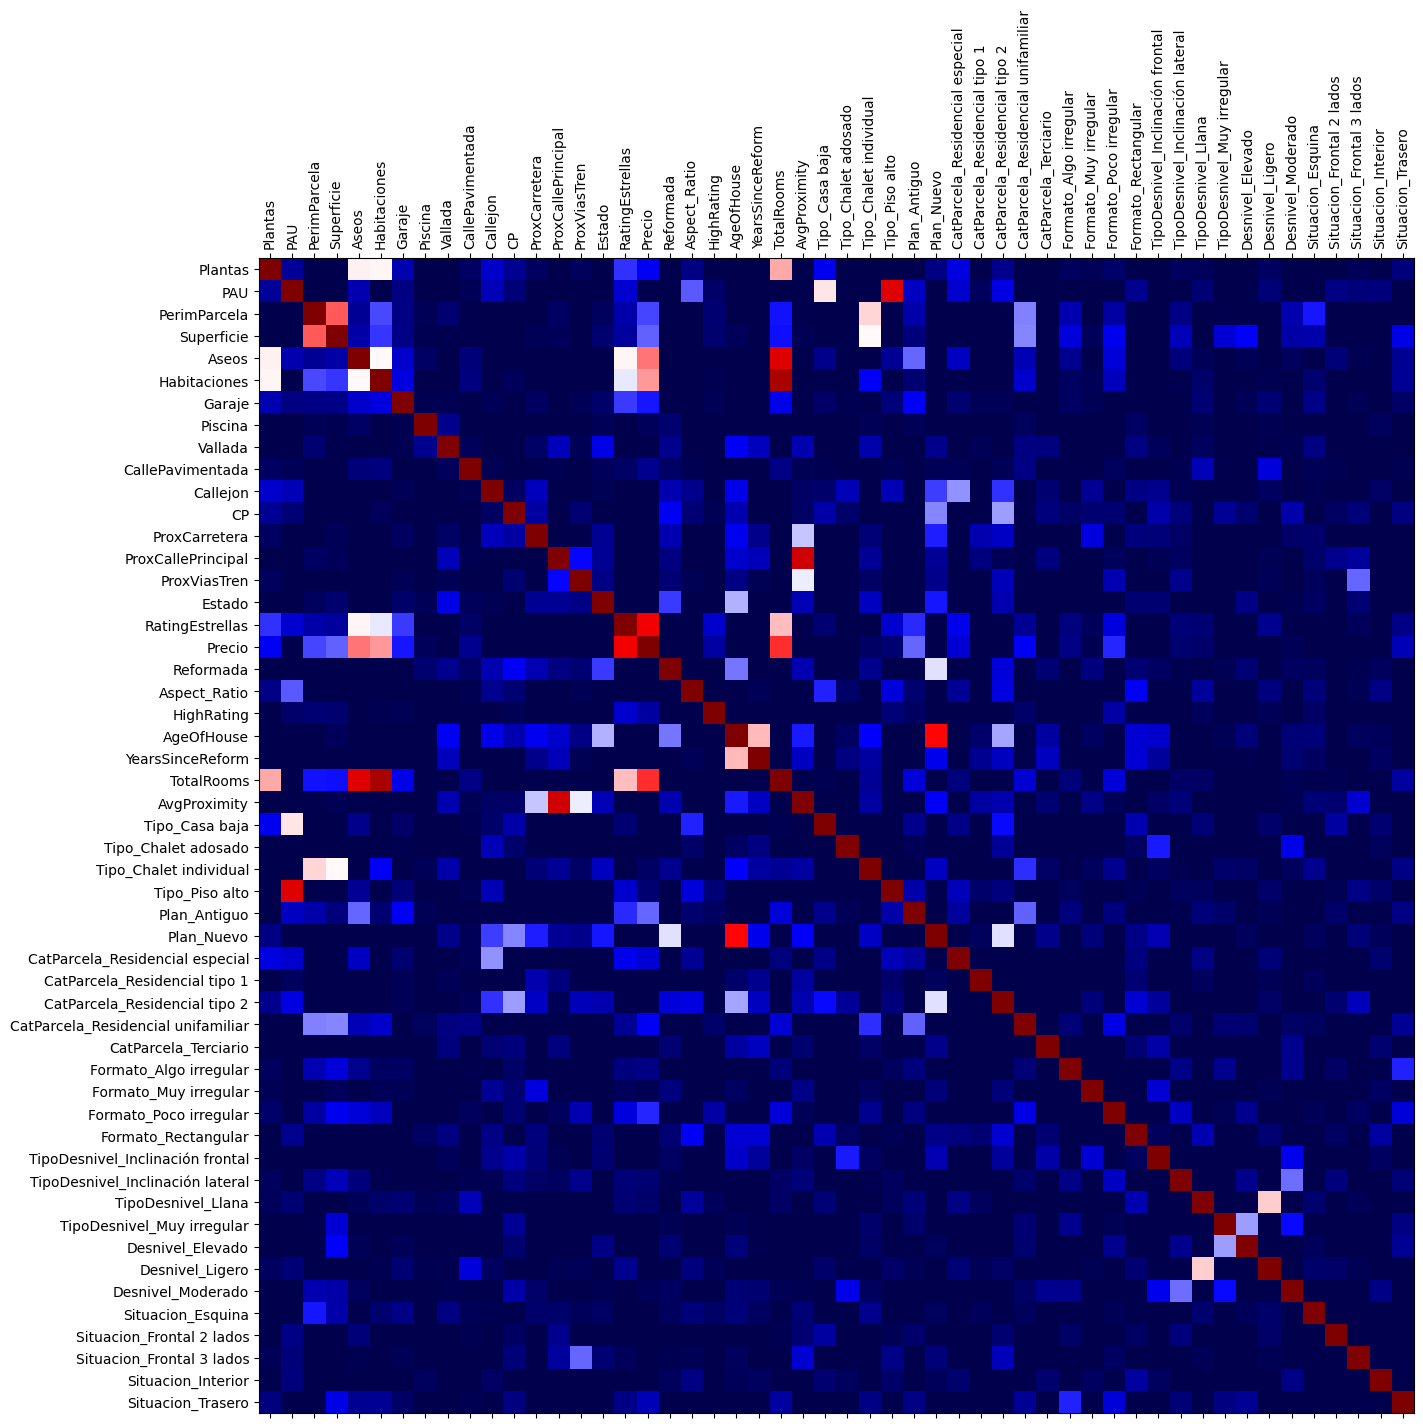

In [5]:
# plot correlation matrix of columns in the dataframe
def plot_correlation_matrix(df):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.matshow(corr, cmap='seismic', vmin=0, vmax=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.show()

plot_correlation_matrix(df)

In [6]:

corr = df.corr()
umbral = 0.5
# Encontrar características altamente correlacionadas
caract_alta_correlación = set()
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > umbral:
            colname = corr.columns[i]
            caract_alta_correlación.add(colname)

# Eliminar características altamente correlacionadas
print(caract_alta_correlación)
df_filtered = df.drop(caract_alta_correlación, axis=1)
df_filtered

{'Formato_Rectangular', 'Tipo_Chalet individual', 'CatParcela_Residencial unifamiliar', 'TotalRooms', 'Aspect_Ratio', 'Tipo_Piso alto', 'Desnivel_Moderado', 'AvgProximity', 'RatingEstrellas', 'YearsSinceReform', 'Plan_Antiguo', 'Habitaciones', 'Situacion_Interior', 'Plan_Nuevo', 'Tipo_Casa baja', 'Desnivel_Ligero', 'PerimParcela', 'Superficie', 'AgeOfHouse', 'Aseos', 'TipoDesnivel_Llana', 'Precio'}


,Plantas,PAU,Garaje,Piscina,Vallada,CallePavimentada,Callejon,CP,ProxCarretera,ProxCallePrincipal,...,Formato_Muy irregular,Formato_Poco irregular,TipoDesnivel_Inclinación frontal,TipoDesnivel_Inclinación lateral,TipoDesnivel_Muy irregular,Desnivel_Elevado,Situacion_Esquina,Situacion_Frontal 2 lados,Situacion_Frontal 3 lados,Situacion_Trasero
0,1.355031,-0.405171,0.192456,-0.043396,-0.466347,0.043396,-0.285154,0.725847,-0.145307,-0.248763,...,0,0,0,0,0,0,0,0,0,0
1,-0.736601,-0.405171,0.192456,-0.043396,-0.466347,0.043396,-0.285154,-1.086757,-0.145307,4.012313,...,0,0,0,0,0,0,0,1,0,0
2,1.355031,-0.405171,0.192456,-0.043396,-0.466347,0.043396,-0.285154,0.725847,-0.145307,-0.248763,...,0,1,0,0,0,0,0,0,0,0
3,1.355031,-0.405171,0.192456,-0.043396,-0.466347,0.043396,-0.285154,1.157204,-0.145307,-0.248763,...,0,1,0,0,0,0,1,0,0,0
4,1.355031,-0.405171,0.192456,-0.043396,-0.466347,0.043396,-0.285154,0.842259,-0.145307,-0.248763,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,1.355031,-0.405171,0.192456,-0.043396,-0.466347,0.043396,3.500269,1.022383,6.869039,-0.248763,...,0,0,0,0,0,0,1,0,0,0
991,1.355031,-0.405171,0.192456,-0.043396,2.140288,0.043396,-0.285154,-1.087479,-0.145307,-0.248763,...,0,0,0,0,0,0,0,0,0,0
992,1.355031,-0.405171,0.192456,-0.043396,-0.466347,0.043396,-0.285154,0.725847,-0.145307,-0.248763,...,0,0,0,0,0,0,0,0,0,0
997,-0.736601,-0.405171,0.192456,-0.043396,-0.466347,0.043396,-0.285154,0.788114,-0.145307,-0.248763,...,0,0,0,0,0,0,0,0,0,0


In [7]:
def x_y_split(df, target):
    return df.drop(target, axis=1), df[target]

train_size = 0.75
train = df.sample(frac=train_size, random_state=1)
test = df.drop(train.index)

X_train, y_train = x_y_split(train, 'Precio')
X_test, y_test = x_y_split(test, 'Precio')
X_train.head()

,Plantas,PAU,PerimParcela,Superficie,Aseos,Habitaciones,Garaje,Piscina,Vallada,CallePavimentada,...,TipoDesnivel_Llana,TipoDesnivel_Muy irregular,Desnivel_Elevado,Desnivel_Ligero,Desnivel_Moderado,Situacion_Esquina,Situacion_Frontal 2 lados,Situacion_Frontal 3 lados,Situacion_Interior,Situacion_Trasero
211,-0.736601,-0.405171,0.610959,0.292905,-0.387882,-0.111639,0.192456,-0.043396,-0.466347,0.043396,...,1,0,0,1,0,1,0,0,0,0
531,-0.736601,-0.405171,-0.361374,-0.521364,-1.525811,-0.891646,0.192456,-0.043396,-0.466347,0.043396,...,1,0,0,1,0,0,0,0,1,0
620,1.355031,-0.405171,0.907097,0.388989,0.750048,2.228381,0.192456,-0.043396,-0.466347,0.043396,...,1,0,0,1,0,0,0,0,1,0
814,-0.736601,-0.405171,-0.868694,0.727082,-0.387882,-0.111639,0.192456,-0.043396,-0.466347,0.043396,...,1,0,0,1,0,0,0,0,0,1
521,-0.736601,-0.405171,0.907097,0.689410,-0.387882,-0.111639,0.192456,-0.043396,-0.466347,0.043396,...,1,0,0,1,0,1,0,0,0,0


In [8]:
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def test_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return y_pred

def visualize_test(y_test, y_pred, ax, model_name):
    paired = sorted(list(zip(y_test, y_pred)))
    y_test_sorted, y_pred_sorted = zip(*paired)
    y_test_sorted = zscore_norm_price_inverse(np.array(y_test_sorted))
    y_pred_sorted = zscore_norm_price_inverse(np.array(y_pred_sorted))

    mae = mean_absolute_error(y_test_sorted, y_pred_sorted)
    mape = mean_absolute_percentage_error(y_test_sorted, y_pred_sorted)
    # print in 10^4 format
    print('MAE: {:.2}'.format(mae/10000))
    print('MAPE: {:.4}'.format(mape))
    # plot y_test and y_pred values to visualize the model performance
    num_range = np.arange(0, len(y_test))
    ax.plot(y_test_sorted, label='y_test', marker='*', color='blue')
    ax.plot(y_pred_sorted, label='y_pred', marker='.', color='red')
    ax.set_title(f'y_test vs y_pred {model_name}')
    ax.legend()

MAE: 3.4
MAPE: 0.121


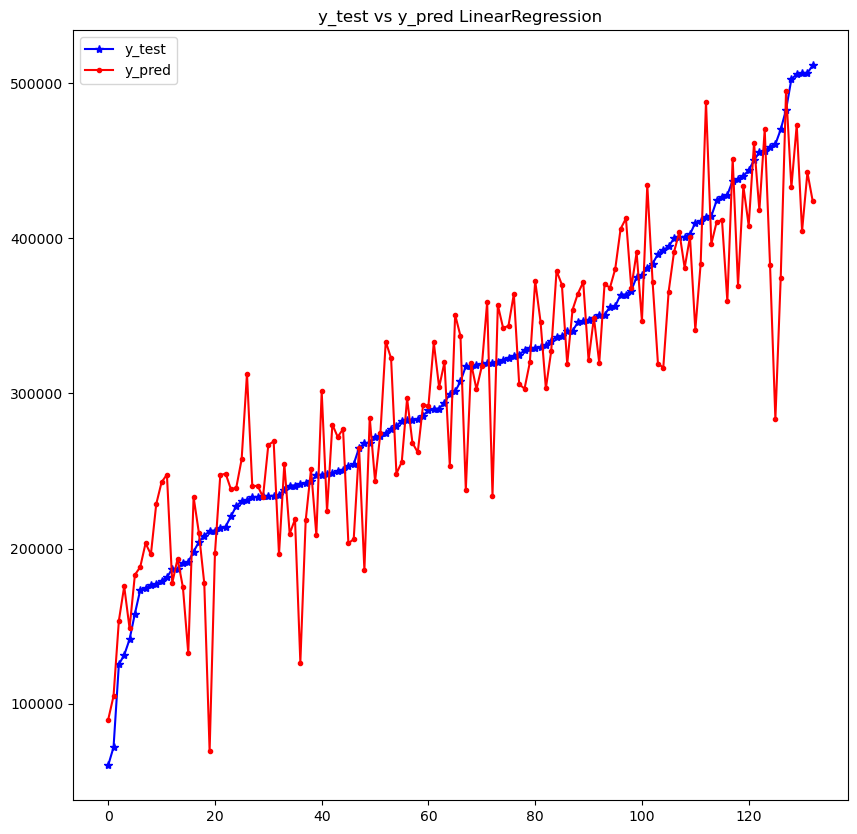

In [9]:
best_combination = {'recall': 0, 'model': None, 'norm': None, 'sampling': None, 'trained_model': None}
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

model = LinearRegression()
model_name = model.__class__.__name__
trained_model = train_model(model, X_train, y_train)
y_pred = test_model(trained_model, X_test, y_test)
visualize_test(y_test, y_pred, ax=axes, model_name=model_name)

MAE: 3.4
MAPE: 0.121
MAE: 6.5
MAPE: 0.2667
MAE: 7.8
MAPE: 0.3206
MAE: 3.3
MAPE: 0.1208
MAE: 4.1
MAPE: 0.1555
MAE: 3.2
MAPE: 0.1252
MAE: 3.1
MAPE: 0.1189
MAE: 3.6
MAPE: 0.1428


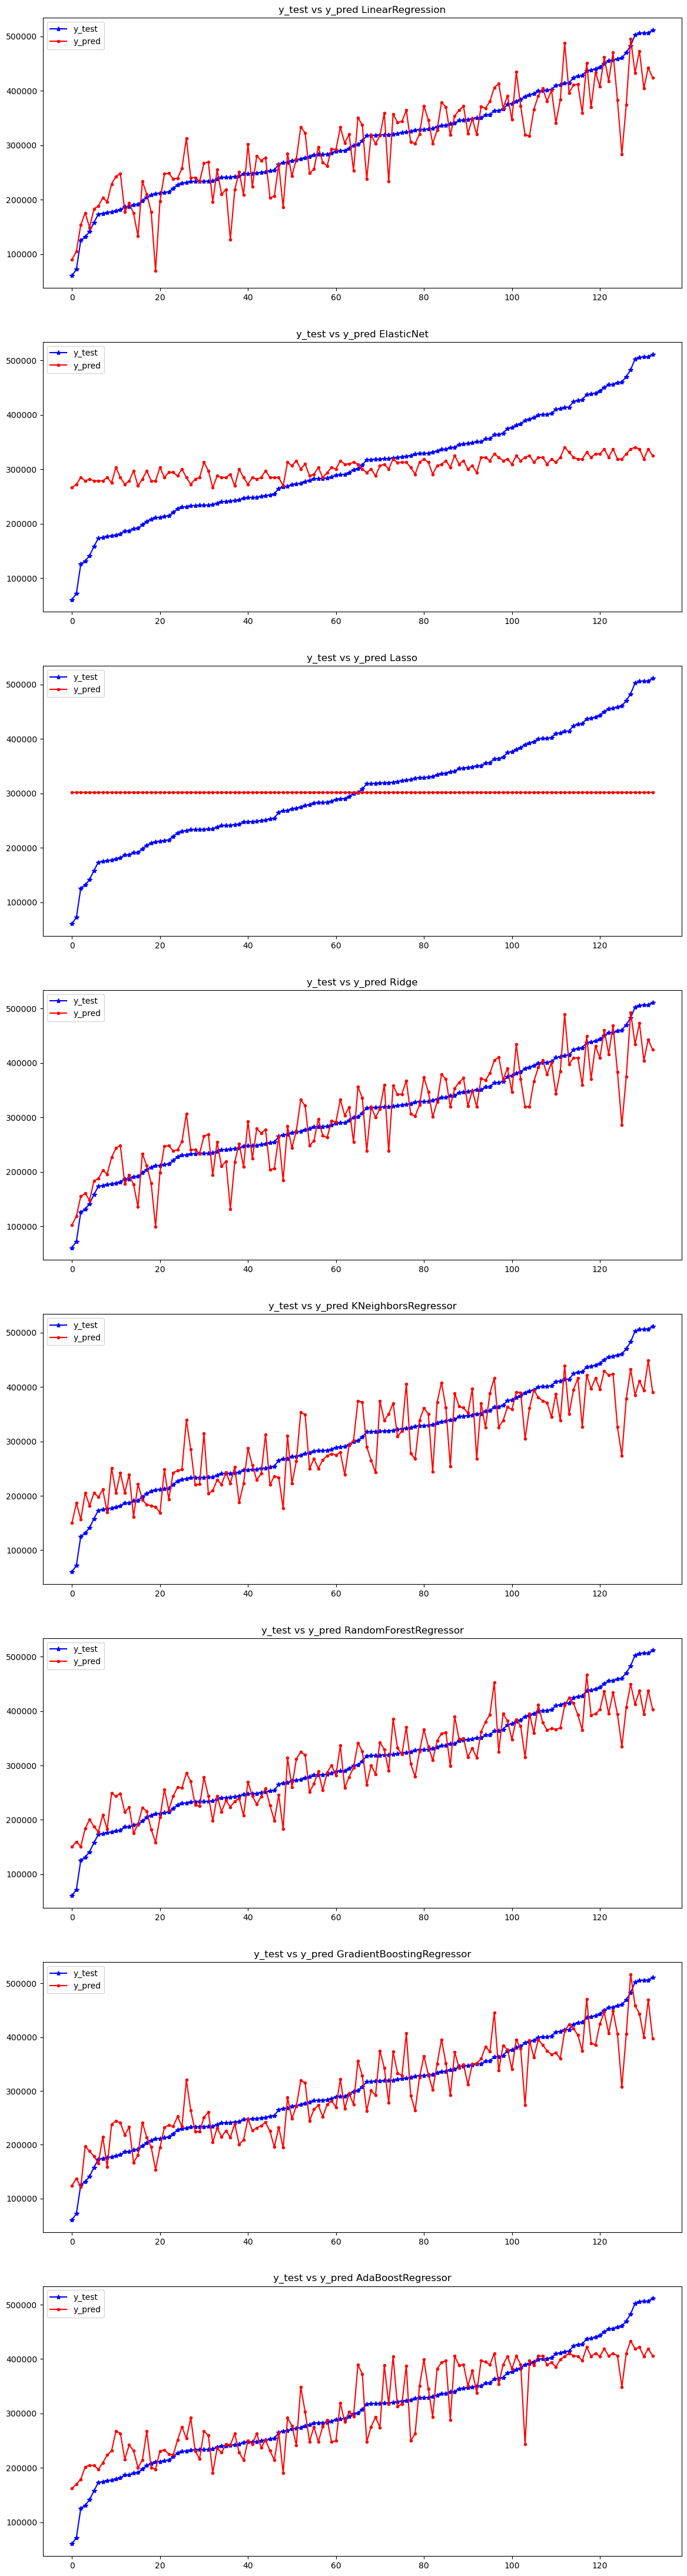

In [10]:
models = [LinearRegression(), ElasticNet(), Lasso(), Ridge(), KNeighborsRegressor(), RandomForestRegressor(), GradientBoostingRegressor(learning_rate=0.01, n_estimators=1000), AdaBoostRegressor()]
# cols and rows for subplots according to number of models
fig, axes = plt.subplots(nrows=len(models), ncols=1, figsize=(14, len(models)*7))

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    trained_model = train_model(model, X_train, y_train)
    y_pred = test_model(trained_model, X_test, y_test)
    visualize_test(y_test, y_pred, ax=axes[i], model_name=model_name)

plt.show()


In [11]:
grad_boost = GradientBoostingRegressor()

distributions = {
    'learning_rate': uniform(0.01, 0.2),
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 7),
    'min_samples_split': uniform(0.01, 0.2),
    'min_samples_leaf': uniform(0.01, 0.1),
    'subsample': uniform(0.8, 0.2),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

clf = RandomizedSearchCV(grad_boost, distributions, random_state=0, n_iter=10000, verbose=1, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')
search = clf.fit(X_train, y_train)
search.best_params_

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits


KeyboardInterrupt: 

MAE: 3.39e+04


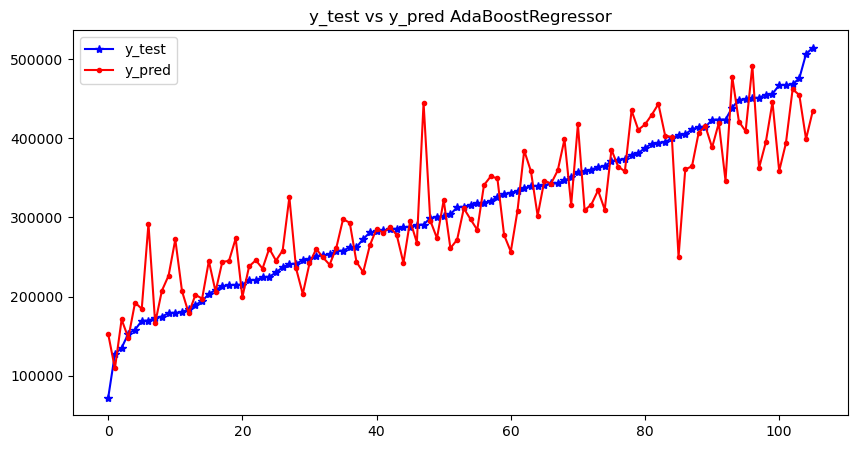

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
visualize_test(y_test, y_pred, ax=axes, model_name=model_name)